## Accelerating Metal-Organic Framework Discovery via Synthesisability Prediction: The MFD Evaluation Method for One-Class Classification Models

Chi Zhang, Dmytro Antypov, Matthew J. Rosseinsky, and Matthew S. Dyer*<br/>
Email: M.S.Dyer@liverpool.ac.uk <br/>

Please cite the corresponding paper if you used the Maximum Fractional Differe (MFD) method or these trained machine learning (ML) models in your work.<br/>

The Jupyter Notebook hereafter presents the predictions of 14 true negative samples. The final result is saved in `negative_samples_final.csv`

# predictions for 6 negative ZIF combinations

In [1]:
import pandas as pd
import numpy as np

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

In [2]:
#insert linker list in ZIF pairs
zif_linker_dict = {'IM':'C1=NC=CN1','mIM':'CC1=NC=CN1','eIM':'CCC1=NC=CN1','nIM':'O=[N+](C1=NC=CN1)[O-]','dcIM':'ClC1=C(Cl)N=CN1','bIM':'C12=CC=CC=C1NC=N2','Pur':'C12=CN=CN=C1NC=N2','cbIM':'ClC1=CC=C2N=CNC2=C1','mbIM':'CC1=C(C)C=C2N=CNC2=C1'}
zif_linker = pd.DataFrame.from_dict(zif_linker_dict, orient='index', columns={'linker_SMILES'})

#convert linker SMILES strings to canonical SMILES strings
for index,row in zif_linker.iterrows():
    linker = row['linker_SMILES']
    mol = Chem.MolFromSmiles(linker)
    zif_linker.at[index, 'linker_SMILES'] = Chem.MolToSmiles(mol)
zif_linker

,linker_SMILES
IM,c1c[nH]cn1
mIM,Cc1ncc[nH]1
eIM,CCc1ncc[nH]1
nIM,O=[N+]([O-])c1ncc[nH]1
dcIM,Clc1nc[nH]c1Cl
bIM,c1ccc2[nH]cnc2c1
Pur,c1ncc2nc[nH]c2n1
cbIM,Clc1ccc2nc[nH]c2c1
mbIM,Cc1cc2nc[nH]c2cc1C


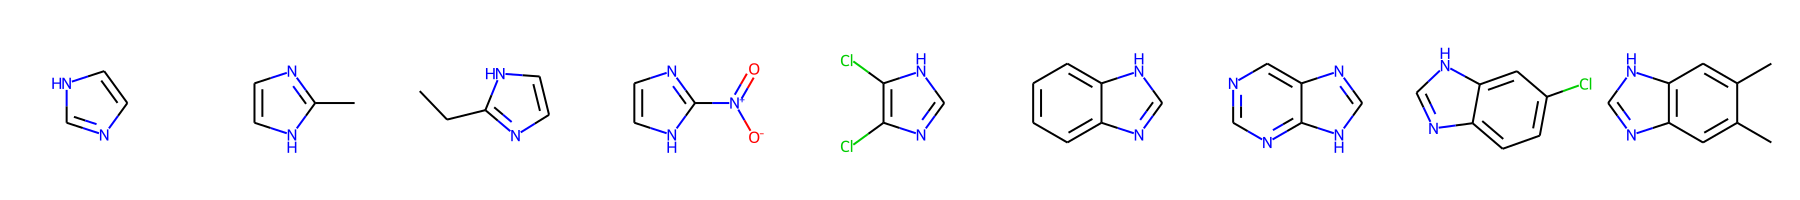

In [3]:
zif_linker_list = zif_linker['linker_SMILES'].tolist()
mols_list = []
for i in zif_linker_list:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=mols_per_row)

In [4]:
#combine linkers with metals
metal_list = ['Zn', 'Co']
zif_pairs = [[metal, linker] for metal in metal_list for linker in zif_linker_list]
zif_pairs_pd = pd.DataFrame(zif_pairs, columns=['metal', 'linker_SMILES'])

#add true labels for each pair
true_value = [1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,0]
zif_pairs_pd['true_value'] = pd.Series(true_value)
zif_pairs_pd

,metal,linker_SMILES,true_value
0,Zn,c1c[nH]cn1,1
1,Zn,Cc1ncc[nH]1,1
2,Zn,CCc1ncc[nH]1,1
3,Zn,O=[N+]([O-])c1ncc[nH]1,1
4,Zn,Clc1nc[nH]c1Cl,1
5,Zn,c1ccc2[nH]cnc2c1,1
6,Zn,c1ncc2nc[nH]c2n1,1
7,Zn,Clc1ccc2nc[nH]c2c1,0
8,Zn,Cc1cc2nc[nH]c2cc1C,0
9,Co,c1c[nH]cn1,1


In [32]:
#load models
import pyod
from pyod.models.iforest import IForest

from joblib import dump, load
clf_iforest = load('models/clf_iforest.joblib')

# Import deep model
import sys
paths = ['../models/Deep-SVDD-PyTorch/', '../models/Deep-SVDD-PyTorch/src', '../models/set_transformer/']
sys.path.extend(paths)

import torch
import torch.nn as nn
from modules import SAB, PMA, ISAB
import deepSVDD
from base.base_net import BaseNet

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
        
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
    return PairsEncoder()

INPUT_DIM = 2253

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=2253, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=10),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 2253, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=2253), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

# load deep model
net_name = 'mof_Net'
clf_deep = deepSVDD.DeepSVDD()
clf_deep.net = build_network(net_name)
clf_deep.ae_net = build_autoencoder(net_name)
clf_deep.net_name = net_name
clf_deep.load_model(model_path='models/deep_model.tar')

C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [37]:
#mordred feature scale
import mordred
from mordred import Calculator, descriptors
print(f'mordred: {mordred.__version__}')

import pickle
with open('dataset/linker_list.pkl','rb') as f:
    linker_list = pickle.load(f)

#create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)
linker_df = pd.DataFrame()

#create descriptors for old linker
for linker in linker_list:
    mol = Chem.MolFromSmiles(linker)  # calculate single molecule
    results = calc(mol).asdict()
    
    for key in results:
        if type(results[key]) == mordred.error.Missing:
            results[key] = None
            
    result_pd = pd.DataFrame(results, index = [linker])    
    linker_df = linker_df.append(result_pd)

print(linker_df.isnull().any().sum())
linker_df = linker_df.fillna(0)
linker_df = linker_df.astype(float).fillna(0)

mordred: 1.2.0


C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


516


MinMaxScaler()

In [66]:
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#import metal features for the input
metal_scaled = pd.read_csv('dataset/metal_scaled_6.csv', index_col=0)
metal_scaled_dl = pd.read_csv('dataset/metal_scaled_205.csv', index_col=0)

#import linker features scale
linker_minmax = pd.read_csv('dataset/linker_scaled_1613.csv',index_col=0)
linker_minmax = linker_minmax.loc[:,(linker_minmax!=0).any(axis=0)]

minmax_scaler = MinMaxScaler()

linker_df = linker_df[linker_df.columns.intersection(linker_minmax.columns)]
minmax_scaler.fit(linker_df)

#generate feature sets for ZIF pairs
for index,row in zif_pairs_pd.iterrows():
    
    metal = row['metal']
    linker = row['linker_SMILES']
    
    metal_df = metal_scaled.loc[metal,:]   #metal features to be used in IForest model
    metal_df_dl = metal_scaled_dl.loc[metal,:]  #metal features to be used in DeepSVDD model

    #generate linker features for the input
    calc = Calculator(descriptors, ignore_3D=True)
    mol = Chem.MolFromSmiles(linker)  # calculate single molecule
    results = calc(mol).asdict()

    for key in results:
        if type(results[key]) == mordred.error.Missing:
            results[key] = None

    result_pd = pd.DataFrame(results, index = [linker])    

    result_pd = result_pd.fillna(0)
    result_pd = result_pd.astype(float).fillna(0) # linker features to be used in IForest
    
    result_pd = result_pd[result_pd.columns.intersection(linker_minmax.columns)]
    result_pd = minmax_scaler.transform(result_pd)
    
    mol = Chem.MolFromSmiles(linker)
    fpts_dl = AllChem.GetMorganFingerprintAsBitVect(mol,3,2048)
    linker_df_dl = np.array(fpts_dl) # linker features to be used in deep model

    #concatenate metal features & linker features
    df = np.concatenate((metal_df.to_numpy(), result_pd[0])) # to be used in IForest
    df_dl = np.concatenate((metal_df_dl.to_numpy(), linker_df_dl)) # to be used in DeepSVDD model
    
    #predict
    output_iforest = clf_iforest.decision_function(df.reshape(1,-1))*(-1)
    
    device = 'cpu'
    def score(deep_SVDD, X):
        with torch.no_grad():
            net = deep_SVDD.net.to(device)
            X = torch.FloatTensor(X).to(device)
            y = net(X)
            c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
            dist = torch.sum((y - c)**2, dim=1)
            if deep_SVDD.objective == 'soft-boundary':
                scores = dist - R ** 2
            else:
                scores = dist
        return scores

    output_deep = score(clf_deep, df_dl.reshape(1,-1)).cpu().detach().numpy()*(-1)
    
  
    zif_pairs_pd.at[index,'iforest_prediction'] = output_iforest
    zif_pairs_pd.at[index,'deepsvdd_prediction'] = output_deep

In [47]:
#get score scaler for IForest and DeepSVDD models 
from sklearn import preprocessing

iforest_scaler = preprocessing.MinMaxScaler()
deepsvdd_scaler = preprocessing.MinMaxScaler()

iforest_train = pd.read_csv('best_poor_models/poor_full_train.csv', index_col=0)
iforest_test = pd.read_csv('best_poor_models/poor_full_test.csv', index_col=0)
iforest_range = np.concatenate((iforest_train,iforest_test)).reshape(-1,1)
iforest_scaler.fit(iforest_range)

deepsvdd_train = pd.read_csv('best_poor_models/DeepSVDD_train.csv', index_col=0)
deepsvdd_test = pd.read_csv('best_poor_models/DeepSVDD_test.csv', index_col=0)
deepsvdd_range = np.concatenate((deepsvdd_train,deepsvdd_test)).reshape(-1,1)
deepsvdd_scaler.fit(deepsvdd_range)

MinMaxScaler()

In [48]:
#generate normalized scores for thr ground_truth dataset and the query dataset to be used to produce Figure 5.
iforest_train_scaled = iforest_scaler.transform(np.array(iforest_train).reshape(-1,1))
iforest_test_scaled = iforest_scaler.transform(np.array(iforest_test).reshape(-1,1))
deepsvdd_train_scaled = deepsvdd_scaler.transform(np.array(deepsvdd_train).reshape(-1,1))
deepsvdd_test_scaled = deepsvdd_scaler.transform(np.array(deepsvdd_test).reshape(-1,1))

In [9]:
#generate normalized scores
for index, row in zif_pairs_pd.iterrows():
    
    output_deep = deepsvdd_scaler.transform(np.array(row['deepsvdd_prediction']).reshape(-1,1))
    output_iforest = iforest_scaler.transform(np.array(row['iforest_prediction']).reshape(-1,1)) 
    
    zif_pairs_pd.at[index,'iforest_prediction_scaled'] = output_iforest[0][0]
    zif_pairs_pd.at[index,'deepsvdd_prediction_scaled'] = output_deep[0][0]
    
#keep only the true negative data
zif_pairs_pd = zif_pairs_pd.loc[zif_pairs_pd['true_value']==0,:]

#generate predictions
for index,row in zif_negative.iterrows():  
    
    iforest_predict = row['iforest_prediction_scaled']>0.91
    zif_negative.at[index,'iforest_predict'] = int(iforest_predict)
    deepsvdd_predict = row['deepsvdd_prediction_scaled']>0.92
    zif_negative.at[index,'deepsvdd_predict'] = int(deepsvdd_predict)
zif_negative

,metal,linker_SMILES,iforest_prediction,deepsvdd_prediction,iforest_prediction_scaled,deepsvdd_prediction_scaled,iforest_predict,deepsvdd_predict
7,Zn,Clc1ccc2nc[nH]c2c1,0.042771,-0.016913,0.812412,0.511396,0.0,0.0
8,Zn,Cc1cc2nc[nH]c2cc1C,0.049108,-0.008059,0.832387,0.770776,0.0,0.0
11,Co,CCc1ncc[nH]1,0.039985,-0.001960,0.803631,0.949463,0.0,1.0
13,Co,Clc1nc[nH]c1Cl,0.001835,-0.005457,0.683376,0.847006,0.0,0.0
16,Co,Clc1ccc2nc[nH]c2c1,0.042806,-0.019511,0.812521,0.435301,0.0,0.0
17,Co,Cc1cc2nc[nH]c2cc1C,0.048906,-0.008076,0.831752,0.770285,0.0,0.0


# predictions for 8 negative samples

In [ ]:
#8 negative combinations
negatives = [['Zr','O=C(CCC(O)=O)NC1=CC=C(C(O)=O)C=C1'],['Zr','O=C(NCC(O)=O)C1=CC=C(C(NCC(O)=O)=O)C=C1'],['Zn','OC([C@H](CO)NC(C1=CNN=C1)=O)=O'],['Zn','O=C(N[C@@H](CC1=CNC=N1)C(O)=O)CN'],['Zn','O=C(N[C@@H](CC(C)C)C(O)=O)CN'],['Zn','O=C(N[C@@H]([C@@H](C)CC)C(O)=O)CN'],['Fe','O=C(NO)C1=CC=C(C(NO)=O)C=C1'],['Fe','O=C(NO)C1=CC=CC(C(NO)=O)=C1']]
neglinker_modified = []
negatives = pd.DataFrame(negatives)
neglinker_list = negatives.iloc[:,1]
for i in neglinker_list:
    mol = Chem.MolFromSmiles(i)
    neglinker_modified.append(Chem.MolToSmiles(mol))

negative_pairs = pd.DataFrame({'metal':negatives.iloc[:,0],
                                'linker_SMILES':pd.Series(neglinker_modified)})

#featurization
for index,row in negative_pairs.iterrows():
    
    metal = row['metal']
    linker = row['linker_SMILES']
    
    metal_df = metal_scaled.loc[metal,:]   #metal features to be used in IForest model
    metal_df_dl = metal_scaled_dl.loc[metal,:]  #metal features to be used in DeepSVDD model

    #generate linker features for the input
    calc = Calculator(descriptors, ignore_3D=True)
    mol = Chem.MolFromSmiles(linker)  # calculate single molecule
    results = calc(mol).asdict()

    for key in results:
        if type(results[key]) == mordred.error.Missing:
            results[key] = None

    result_pd = pd.DataFrame(results, index = [linker])    

    result_pd = result_pd.fillna(0)
    result_pd = result_pd.astype(float).fillna(0) # linker features to be used in IForest
    
    result_pd = result_pd[result_pd.columns.intersection(linker_minmax.columns)]
    result_pd = minmax_scaler.transform(result_pd)
    
    mol = Chem.MolFromSmiles(linker)
    fpts_dl = AllChem.GetMorganFingerprintAsBitVect(mol,3,2048)
    linker_df_dl = np.array(fpts_dl) # linker features to be used in deep model

    #concatenate metal features & linker features
    df = np.concatenate((metal_df.to_numpy(), result_pd[0])) # to be used in IForest
    df_dl = np.concatenate((metal_df_dl.to_numpy(), linker_df_dl)) # to be used in DeepSVDD model
    
    #predict
    output_iforest = clf_iforest.decision_function(df.reshape(1,-1))*(-1)
    
    device = 'cpu'
    def score(deep_SVDD, X):
        with torch.no_grad():
            net = deep_SVDD.net.to(device)
            X = torch.FloatTensor(X).to(device)
            y = net(X)
            c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
            dist = torch.sum((y - c)**2, dim=1)
            if deep_SVDD.objective == 'soft-boundary':
                scores = dist - R ** 2
            else:
                scores = dist
        return scores

    output_deep = score(clf_deep, df_dl.reshape(1,-1)).cpu().detach().numpy()*(-1)
    
  
    negative_pairs.at[index,'iforest_prediction'] = output_iforest
    negative_pairs.at[index,'deepsvdd_prediction'] = output_deep
    
#generate normalized scores
for index, row in negative_pairs.iterrows():
    
    output_deep = deepsvdd_scaler.transform(np.array(row['deepsvdd_prediction']).reshape(-1,1))
    output_iforest = iforest_scaler.transform(np.array(row['iforest_prediction']).reshape(-1,1)) 
    
    negative_pairs.at[index,'iforest_prediction_scaled'] = output_iforest[0][0]
    negative_pairs.at[index,'deepsvdd_prediction_scaled'] = output_deep[0][0]

In [14]:
#generate predictions
for index,row in negative_pairs.iterrows():     
    iforest_predict = row['iforest_prediction_scaled']>0.91
    negative_pairs.at[index,'iforest_predict'] = int(iforest_predict)
    deepsvdd_predict = row['deepsvdd_prediction_scaled']>0.92
    negative_pairs.at[index,'deepsvdd_predict'] = int(deepsvdd_predict)
    
negative_pairs

,metal,linker_SMILES,iforest_prediction,deepsvdd_prediction,iforest_prediction_scaled,deepsvdd_prediction_scaled,iforest_predict,deepsvdd_predict
0,Zr,O=C(O)CCC(=O)Nc1ccc(C(=O)O)cc1,0.093260,-0.013267,0.971561,0.618212,1.0,0.0
1,Zr,O=C(O)CNC(=O)c1ccc(C(=O)NCC(=O)O)cc1,0.089521,-0.002369,0.959775,0.937456,1.0,1.0
2,Zn,O=C(N[C@@H](CO)C(=O)O)c1cn[nH]c1,0.081285,-0.010842,0.933811,0.689260,1.0,0.0
3,Zn,NCC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)O,0.078911,-0.008535,0.926329,0.756832,1.0,0.0
4,Zn,CC(C)C[C@H](NC(=O)CN)C(=O)O,0.065160,-0.008168,0.882986,0.767595,0.0,0.0
5,Zn,CC[C@H](C)[C@H](NC(=O)CN)C(=O)O,0.066335,-0.014289,0.886689,0.588272,0.0,0.0
6,Fe,O=C(NO)c1ccc(C(=O)NO)cc1,0.082196,-0.006044,0.936686,0.829796,1.0,0.0
7,Fe,O=C(NO)c1cccc(C(=O)NO)c1,0.086453,-0.011209,0.950102,0.678494,1.0,0.0


[0.9715608711271038, 0.9597748983298191, 0.9338114524237441, 0.9263293084076456, 0.8829864903242136, 0.8866893083583287, 0.9366856297517205, 0.950102152504164, 0.8124124074865555, 0.8323873117188014, 0.803630571422655, 0.6833763084164847, 0.8125209821045909, 0.8317516447812676]
[0.6182117890854801, 0.9374556268941346, 0.6892603182726503, 0.7568321787559421, 0.767595097138759, 0.5882721249114309, 0.8297956946745692, 0.6784944264125785, 0.5113959363606901, 0.7707761584404957, 0.9494630584138417, 0.8470060300168128, 0.4353014587249592, 0.7702849205764597]


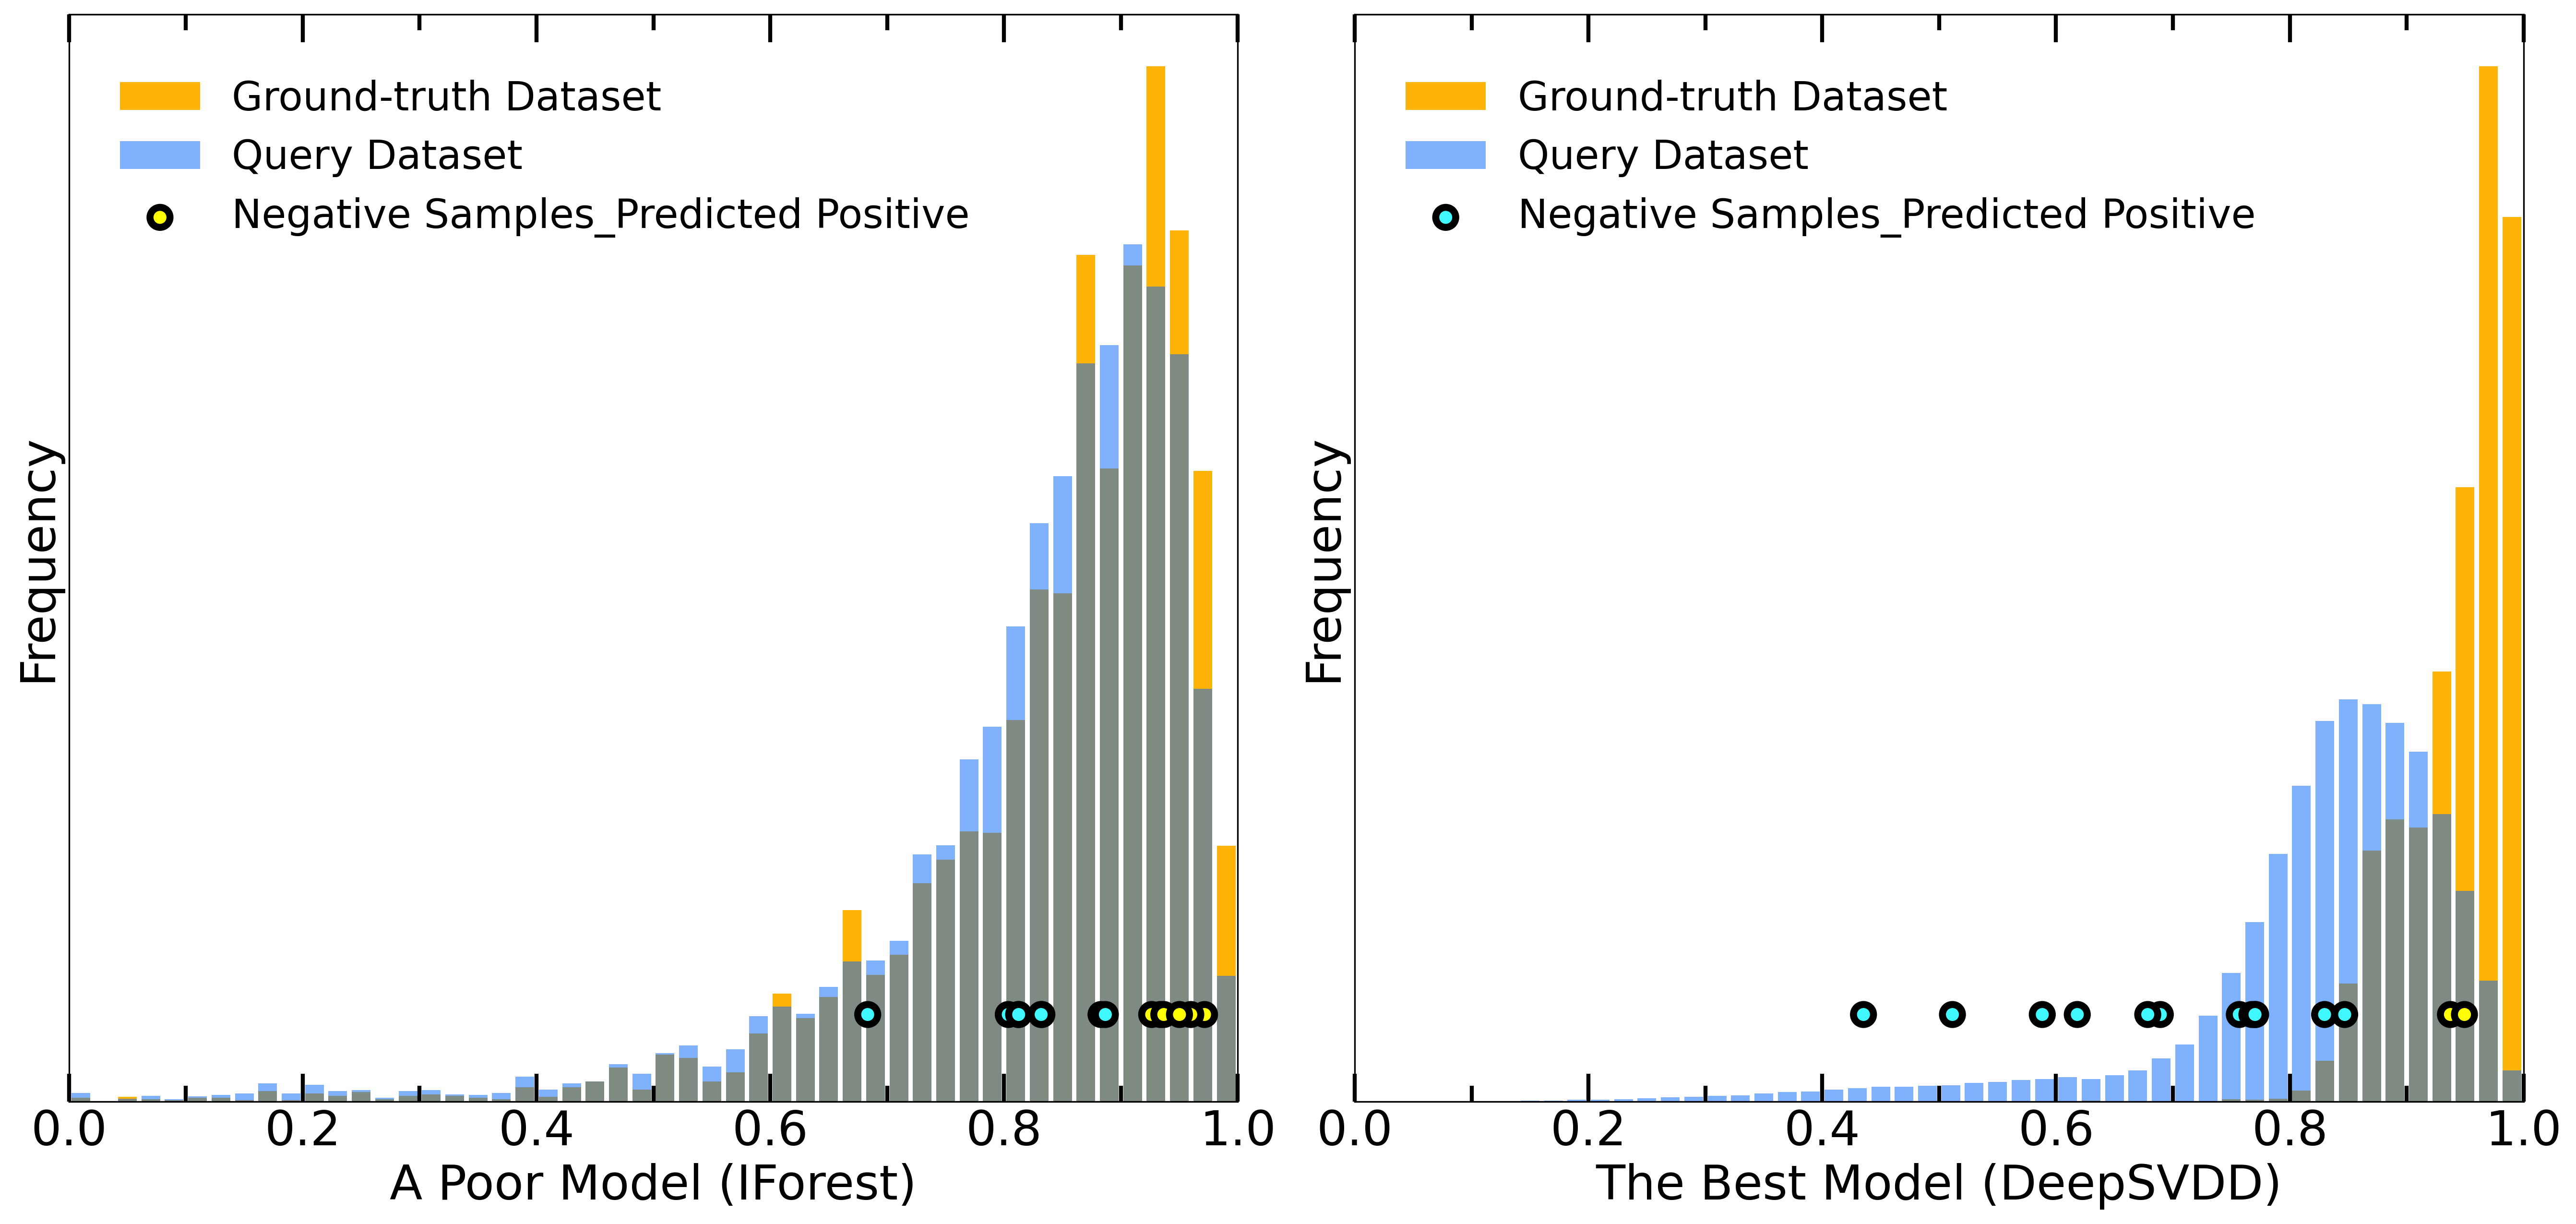

In [16]:
import matplotlib.pyplot as plt
import numpy as np
MinMax_scaler = preprocessing.MinMaxScaler()

train_result = [iforest_train_scaled,deepsvdd_train_scaled]
test_result = [iforest_test_scaled,deepsvdd_test_scaled]
model_name = ['A Poor Model (IForest)','The Best Model (DeepSVDD)']

val_result = [zif_negative['iforest_prediction_scaled'], zif_negative['deepsvdd_prediction_scaled']]
negative_pairs_result = [negative_pairs['iforest_prediction_scaled'], negative_pairs['deepsvdd_prediction_scaled']]

%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(22,10),dpi=300)

for i in np.arange(2):
    # score scaler
    if i == 0:    
        scores_bins = iforest_scaler.transform(iforest_range)
    elif i == 1:
        scores_bins = deepsvdd_scaler.transform(deepsvdd_range)
    
    train_scores = train_result[i]
    test_scores = test_result[i]
    
    ax = plt.subplot(1,2,i+1)
    _, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
    plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Ground-truth Dataset')
    _= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset')   
    
    #8 negative samples & 6 zif negative samples
    ymin, ymax = ax.get_ylim()
    y_position = np.ones((14,1), dtype = int) 
    y_position = y_position*(ymax-ymin)*0.08
    
    sample_comb = negative_pairs_result[i].tolist()+val_result[i].tolist()
    print(sample_comb)
    
    color_list = []
    for element in sample_comb:
        if i == 0:
            if element >= 0.91:
                color_list.append('yellow')
            else:
                color_list.append('#40F8FF')
        elif i==1:
            if element >= 0.92:
                color_list.append('yellow')
            else:
                color_list.append('#40F8FF')
    
    plt.scatter(sample_comb, y_position, color=color_list, edgecolor='black', marker='o', s=100, linewidths=3.5, label='Negative Samples_Predicted Positive')
    
    plt.grid(False)
    plt.xlim(0, 1.0)
    plt.xlabel(model_name[i], fontsize=24)
    plt.ylabel('Frequency', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks([])
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    major_ticks_x = np.arange(0, 1.001, 0.2)
    minor_ticks_x = np.arange(0,1.001, 0.1)
    ax.tick_params(axis = 'both', which='both', width=2)
    ax.tick_params(axis = 'both', which='major', length=14)
    ax.tick_params(axis = 'both', which='minor', length=8, color='black')
    ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)

    plt.legend(prop={'size': 20}, loc=[0.03, 0.78], frameon=False)
   
plt.subplots_adjust(wspace=0.1)
plt.show()  

In [20]:
negative_samples = pd.concat([negative_pairs, zif_negative], ignore_index=True)
#save results
negative_samples.to_csv('negative_samples_final.csv')
negative_samples

,metal,linker_SMILES,iforest_prediction,deepsvdd_prediction,iforest_prediction_scaled,deepsvdd_prediction_scaled,iforest_predict,deepsvdd_predict
0,Zr,O=C(O)CCC(=O)Nc1ccc(C(=O)O)cc1,0.093260,-0.013267,0.971561,0.618212,1.0,0.0
1,Zr,O=C(O)CNC(=O)c1ccc(C(=O)NCC(=O)O)cc1,0.089521,-0.002369,0.959775,0.937456,1.0,1.0
2,Zn,O=C(N[C@@H](CO)C(=O)O)c1cn[nH]c1,0.081285,-0.010842,0.933811,0.689260,1.0,0.0
3,Zn,NCC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)O,0.078911,-0.008535,0.926329,0.756832,1.0,0.0
4,Zn,CC(C)C[C@H](NC(=O)CN)C(=O)O,0.065160,-0.008168,0.882986,0.767595,0.0,0.0
5,Zn,CC[C@H](C)[C@H](NC(=O)CN)C(=O)O,0.066335,-0.014289,0.886689,0.588272,0.0,0.0
6,Fe,O=C(NO)c1ccc(C(=O)NO)cc1,0.082196,-0.006044,0.936686,0.829796,1.0,0.0
7,Fe,O=C(NO)c1cccc(C(=O)NO)c1,0.086453,-0.011209,0.950102,0.678494,1.0,0.0
8,Zn,Clc1ccc2nc[nH]c2c1,0.042771,-0.016913,0.812412,0.511396,0.0,0.0
9,Zn,Cc1cc2nc[nH]c2cc1C,0.049108,-0.008059,0.832387,0.770776,0.0,0.0


# calculate metrics

In [110]:
#TNR
iforest_TNR = np.sum(negative_samples['iforest_predict']==0)/negative_samples.shape[0]
print('iforest TNR: ',iforest_TNR)
deepsvdd_TNR = np.sum(negative_samples['deepsvdd_predict']==0)/negative_samples.shape[0]
print('deepsvdd TNR: ',deepsvdd_TNR)

iforest TNR:  0.5714285714285714
deepsvdd TNR:  0.8571428571428571
